# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3) - Parte 2: Análisis e imputación de NaNs

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías y dataset

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer

# Funciones propias
from tp3_utils_cluster import *
%load_ext autoreload
%autoreload 2

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

In [2]:
tp3 = pd.read_csv('../data/interim/tp3_vendedores_vector.csv')
tp3 = tp3.drop(columns='Omega').copy()

---
# Identificación de datos faltantes

## Sin distinguir por subrubro

Vemos que hay una gran cantidad de datos faltantes en todas las variables asociadas a la variación porcentual. Más aún: ninguna de estas columnas posee el 100% de los datos. Para cada grupo de variables (según sea comisión/ventas o anual/cuatrimestral) la cantidad de datos faltantes disminuye al progresar en el tiempo (lo cual tiene sentido).

Las variables asociadas a la comisión presentan más datos faltantes que aquellas asociadas a las ventas. Dentro de ventas, hay más datos en el caso cuatrimestral que en el caso anual.

**Nota:** En la gráfica aparecen, desde arriba hacia abajo, ventas anuales, comisión anuales, ventas cuatrimestrales y comisión cuatrimestrales. Dentro de cada grupo, aparecen desde el mes más reciente hacia el más antigüo.

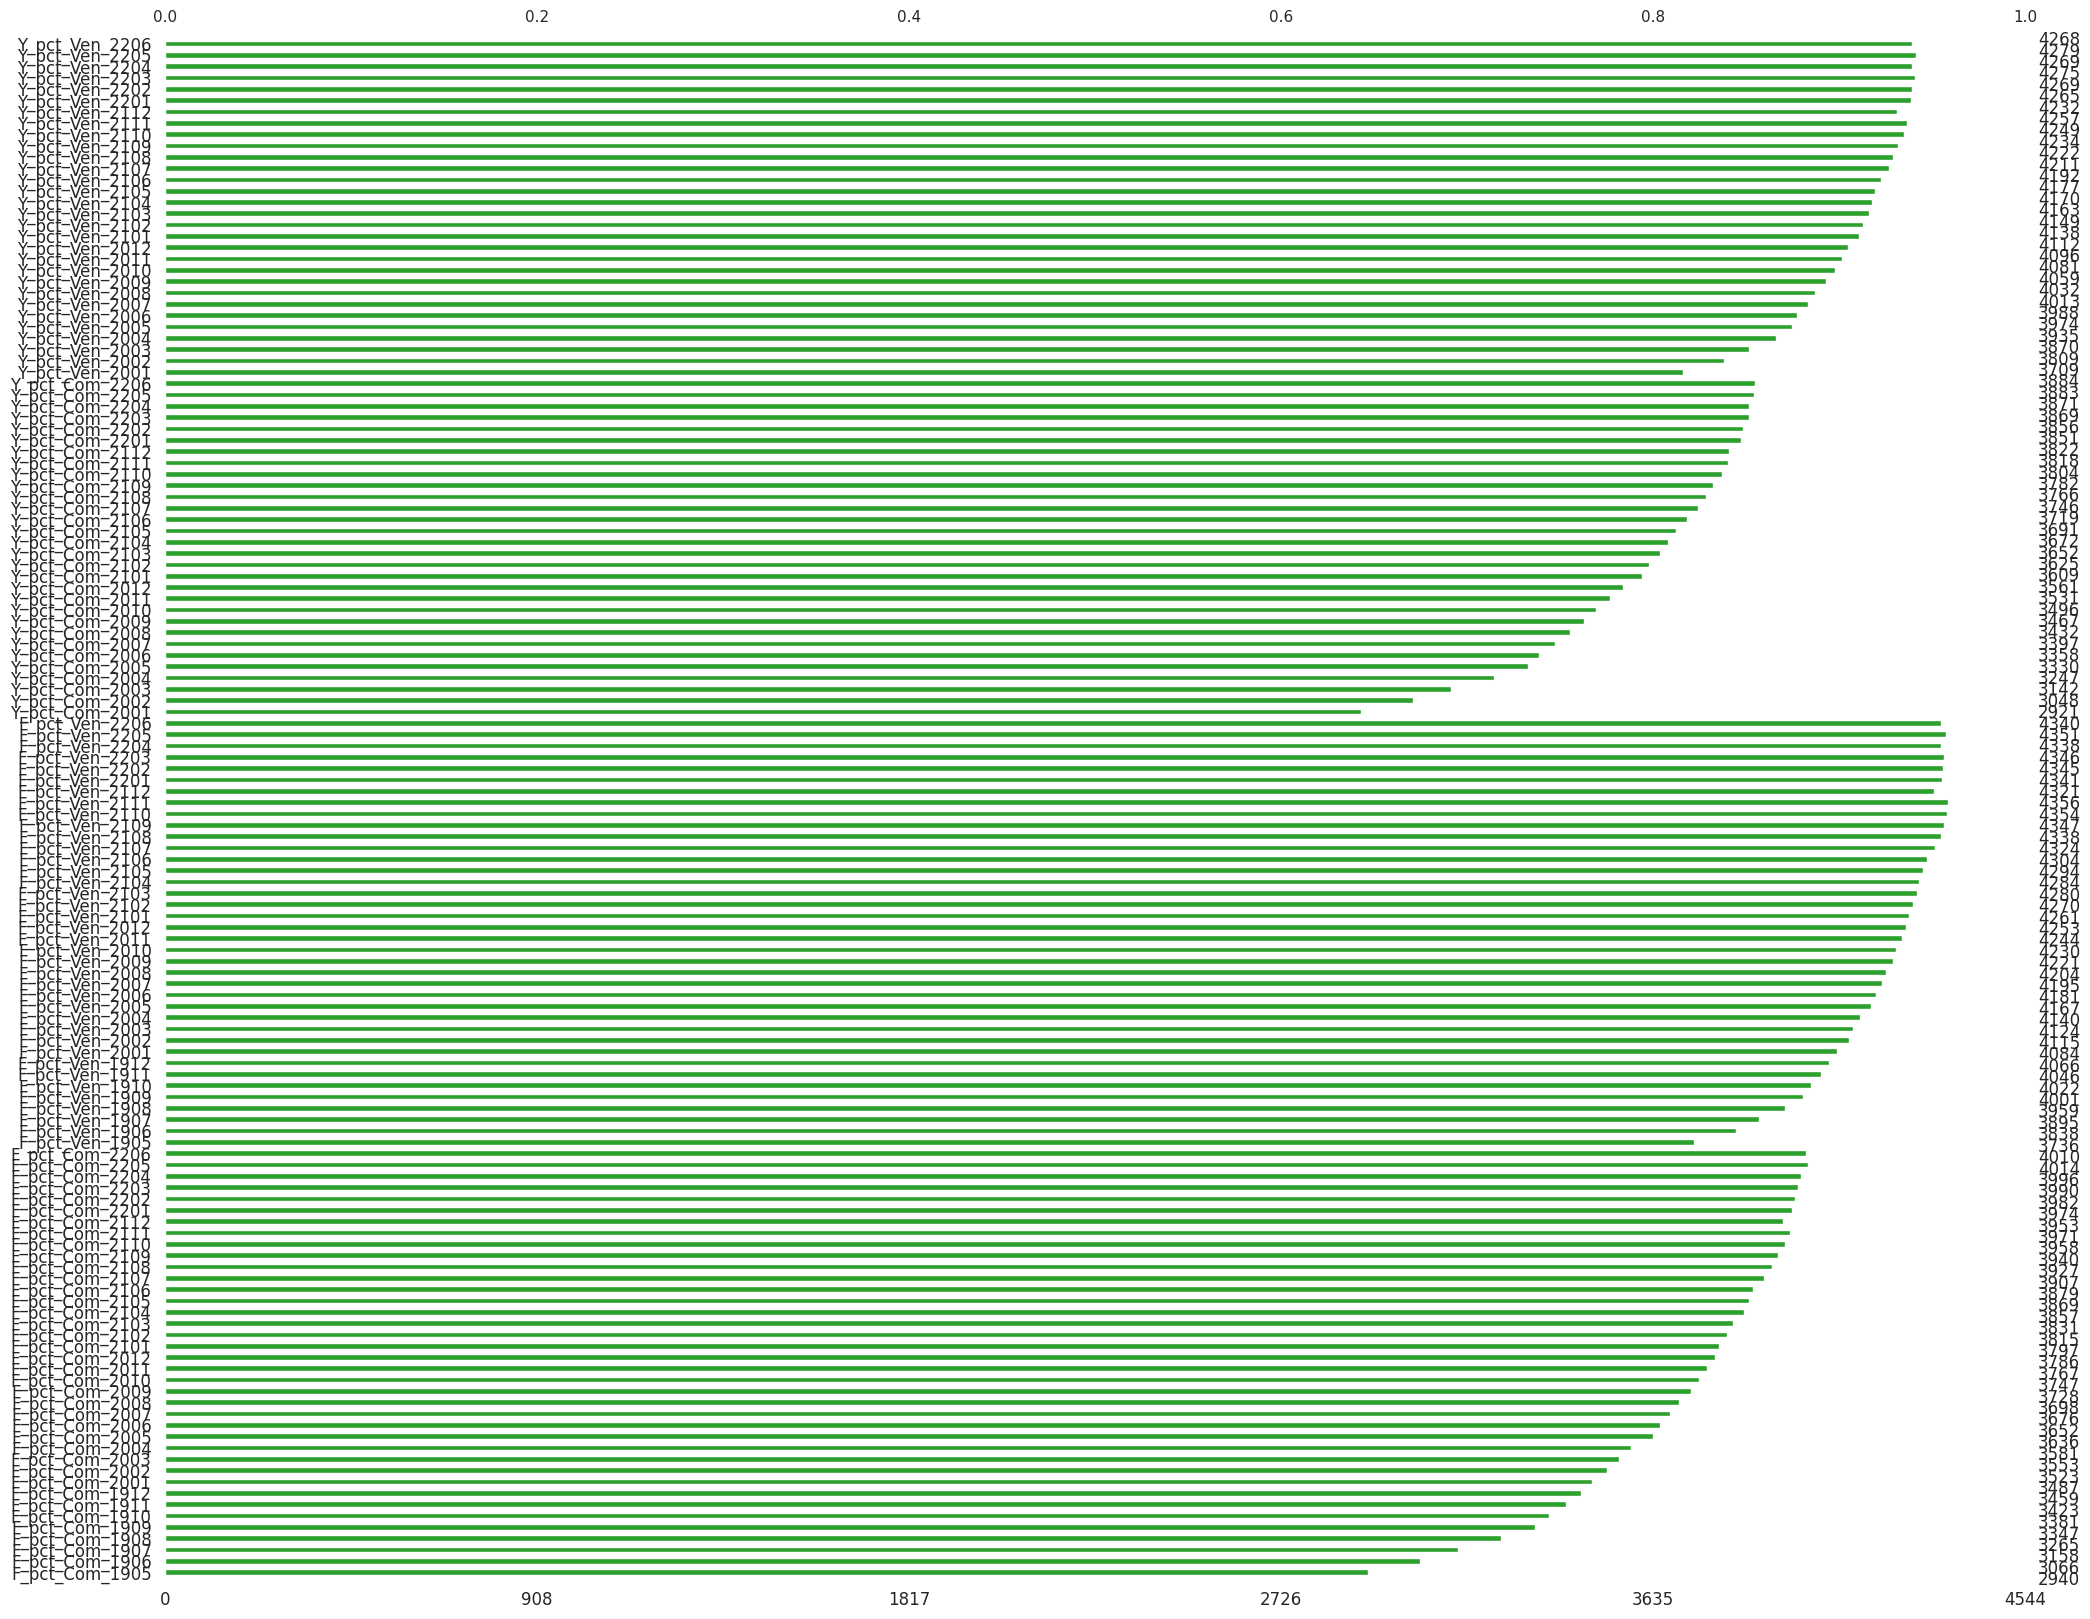

In [3]:
msno.bar(tp3.iloc[:, 3:], fontsize=12, color="tab:green", figsize=(24, 20))
plt.show()

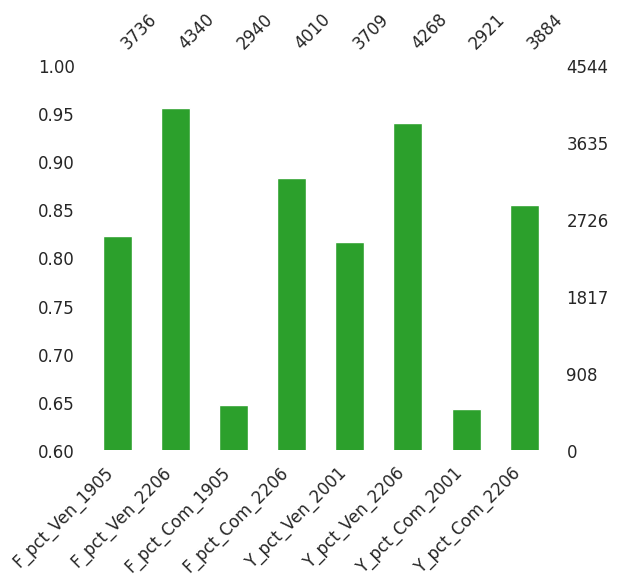

In [4]:
msno.bar(tp3[['F_pct_Ven_1905', 'F_pct_Ven_2206', 'F_pct_Com_1905', 'F_pct_Com_2206', 'Y_pct_Ven_2001', 'Y_pct_Ven_2206', 'Y_pct_Com_2001', 'Y_pct_Com_2206']], fontsize=12, color="tab:green", figsize=(6, 5))
plt.ylim(0.6, 1)
plt.show()

Por lo antes dicho, seguiremos el análisis con la ventas intercuatrimestrales.

In [5]:
basics = ['ID', 'Subrubro', 'Modelo']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

tp3_Fven = tp3[basics+F_Ven].copy()

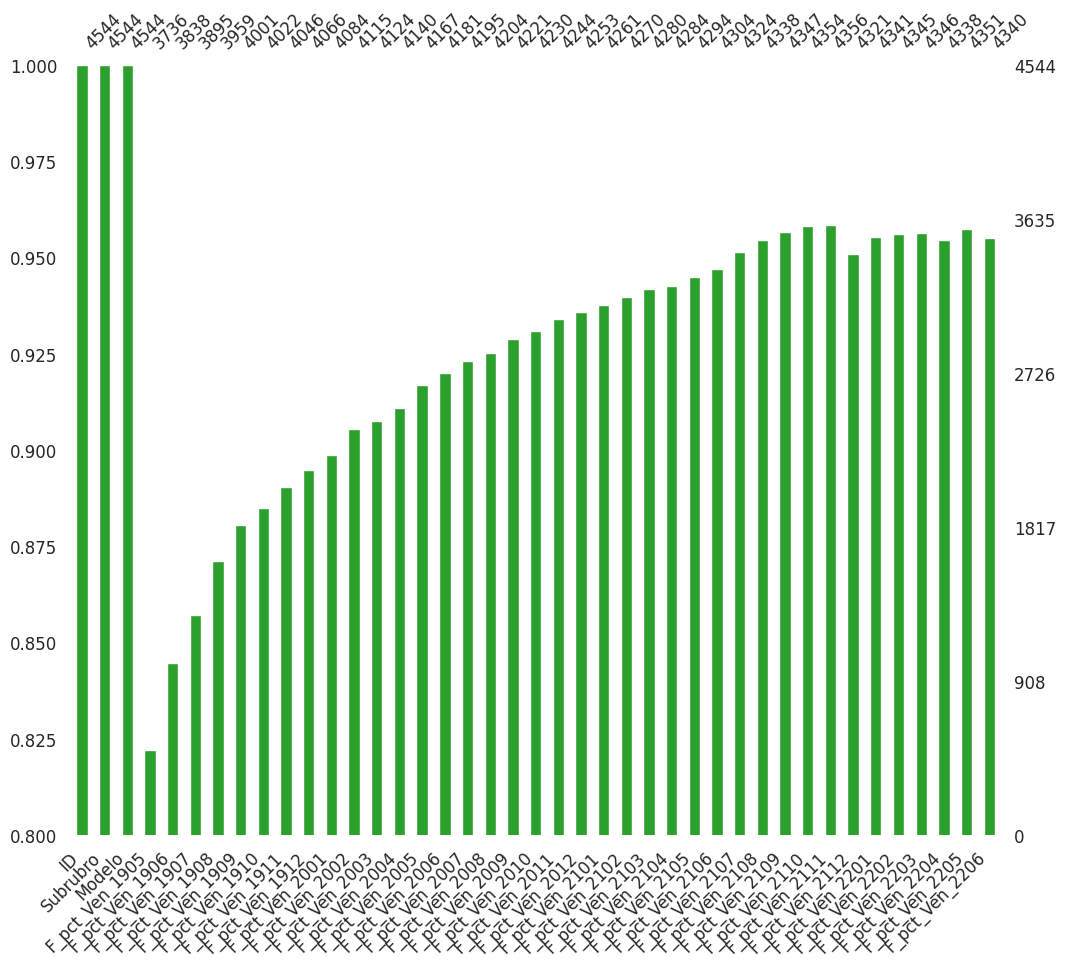

In [6]:
msno.bar(tp3_Fven, fontsize=12, color="tab:green", figsize=(12, 10))
plt.ylim(0.8, 1)
plt.show()

## Diferenciando por subrubro

Hay de todo un poco. Algunos casos presentan menos de 80% de los datos. La mayoría sigue la tendencia de ir aumentando a medida que pasa el tiempo. Algunos son más "consistentes" que otros.

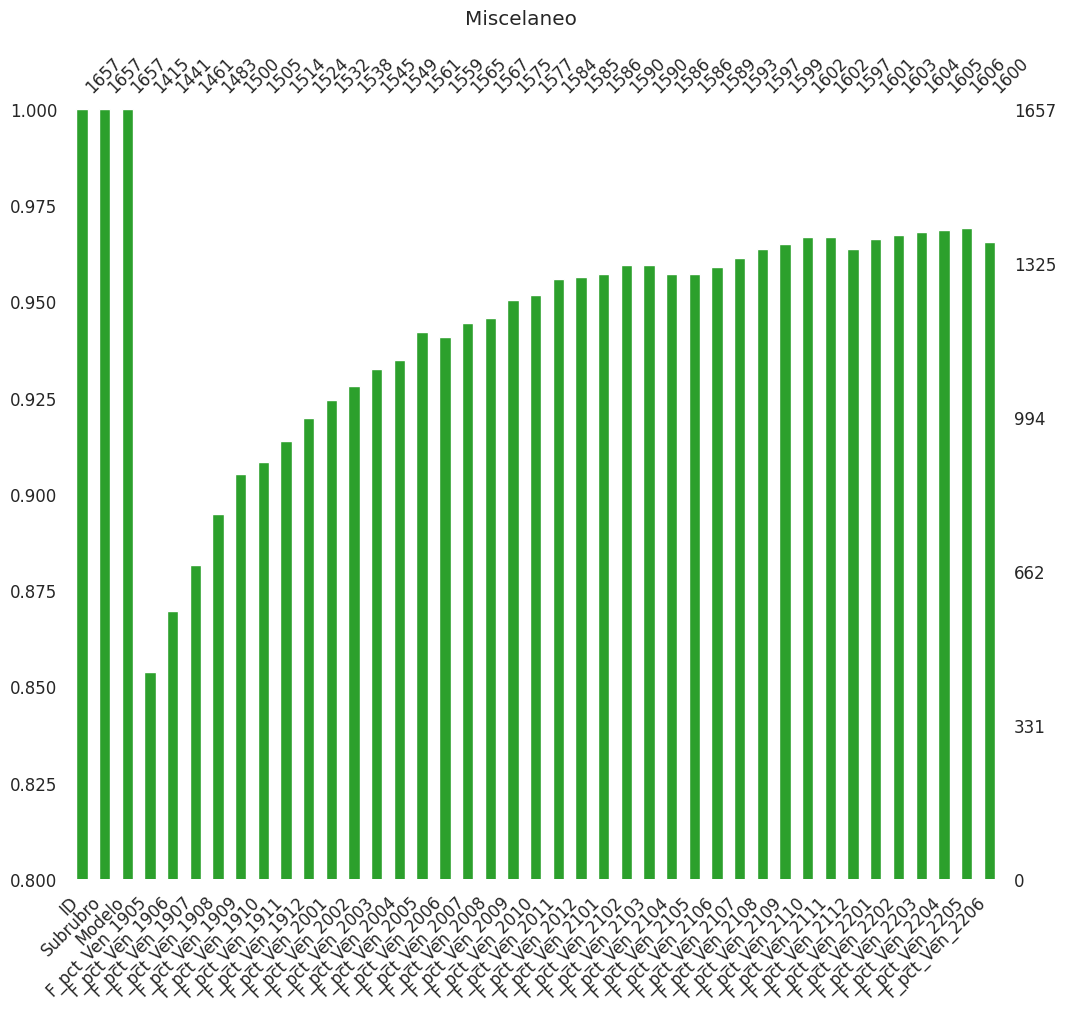

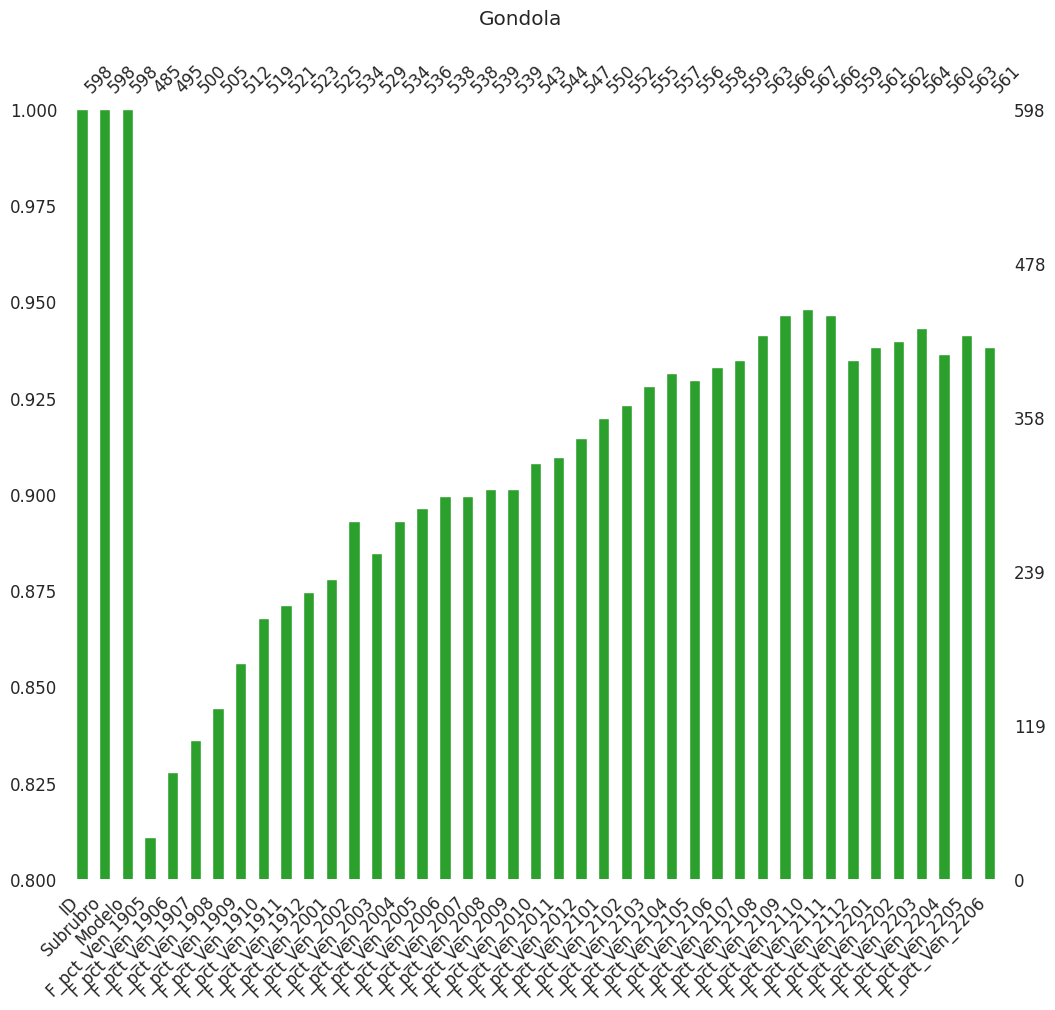

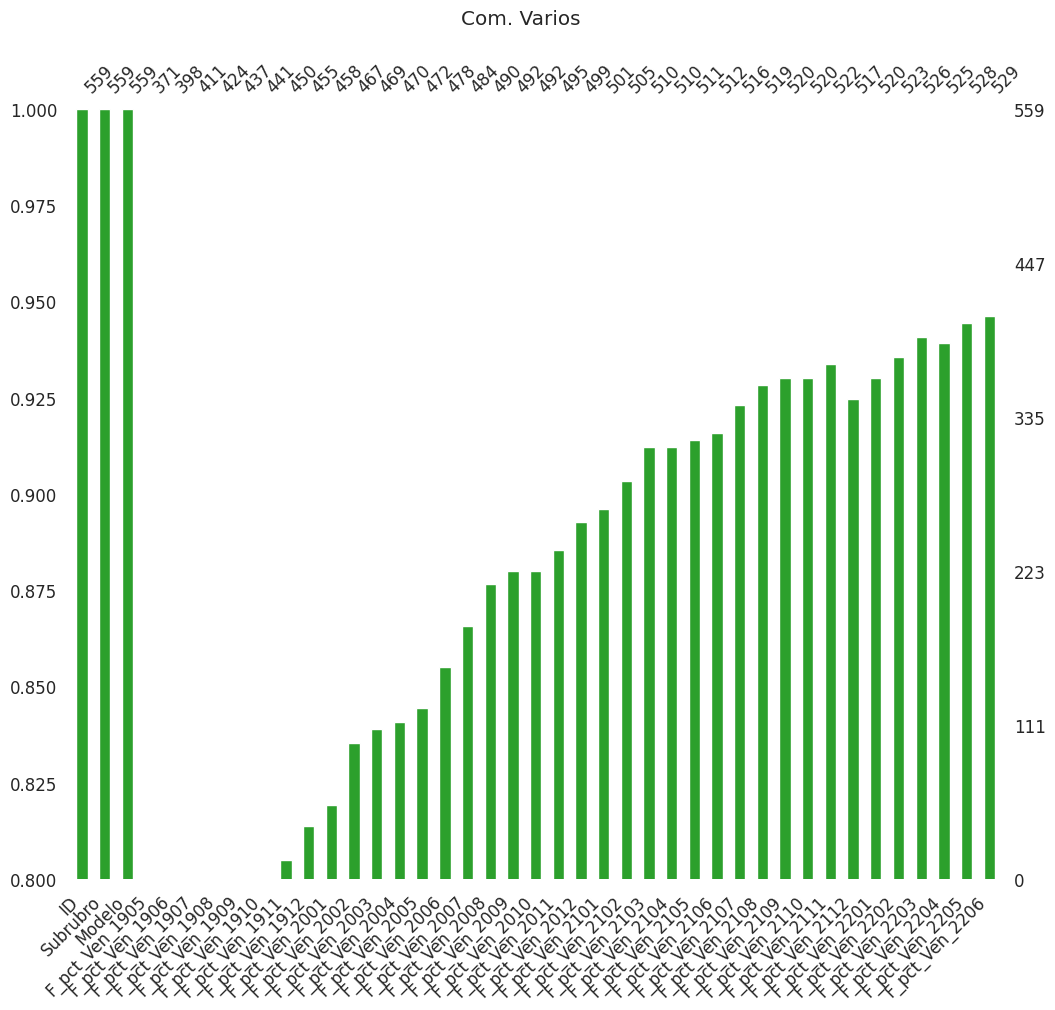

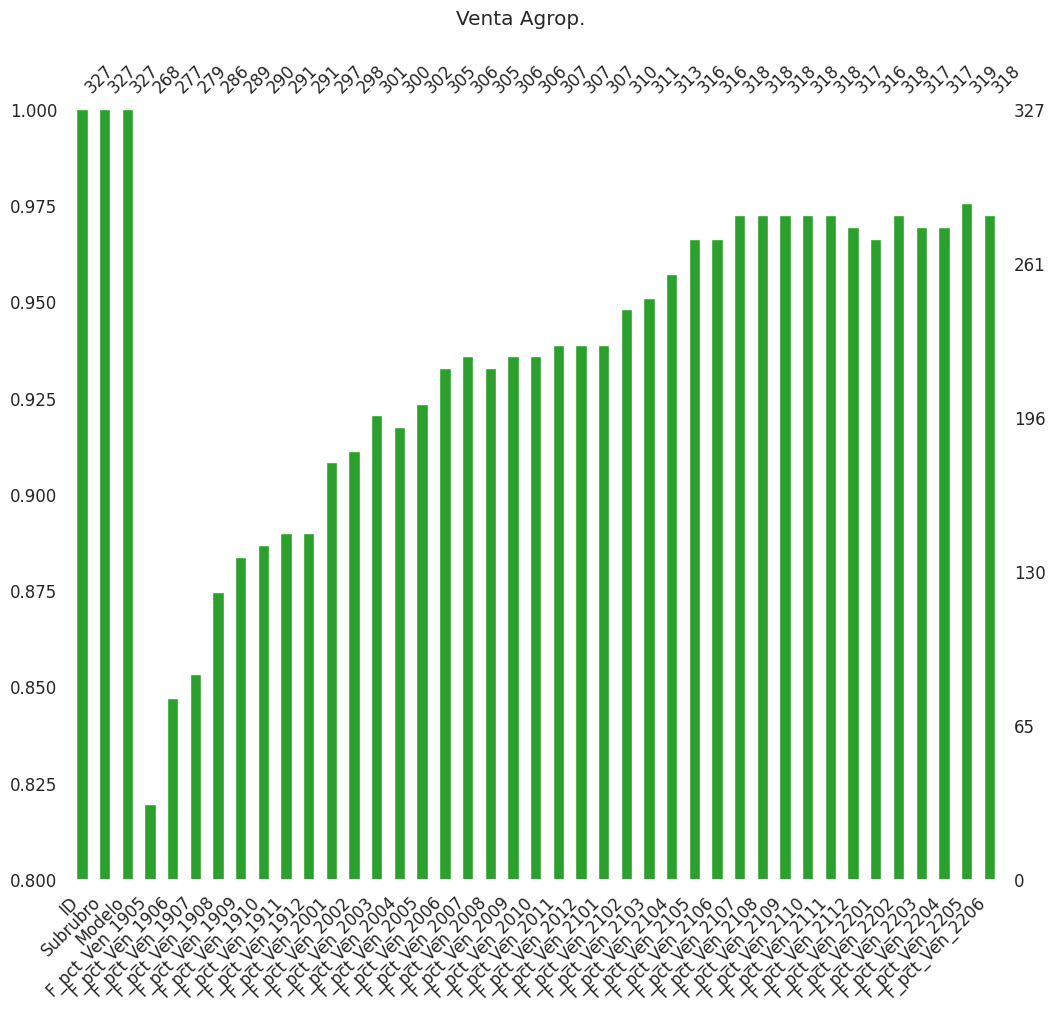

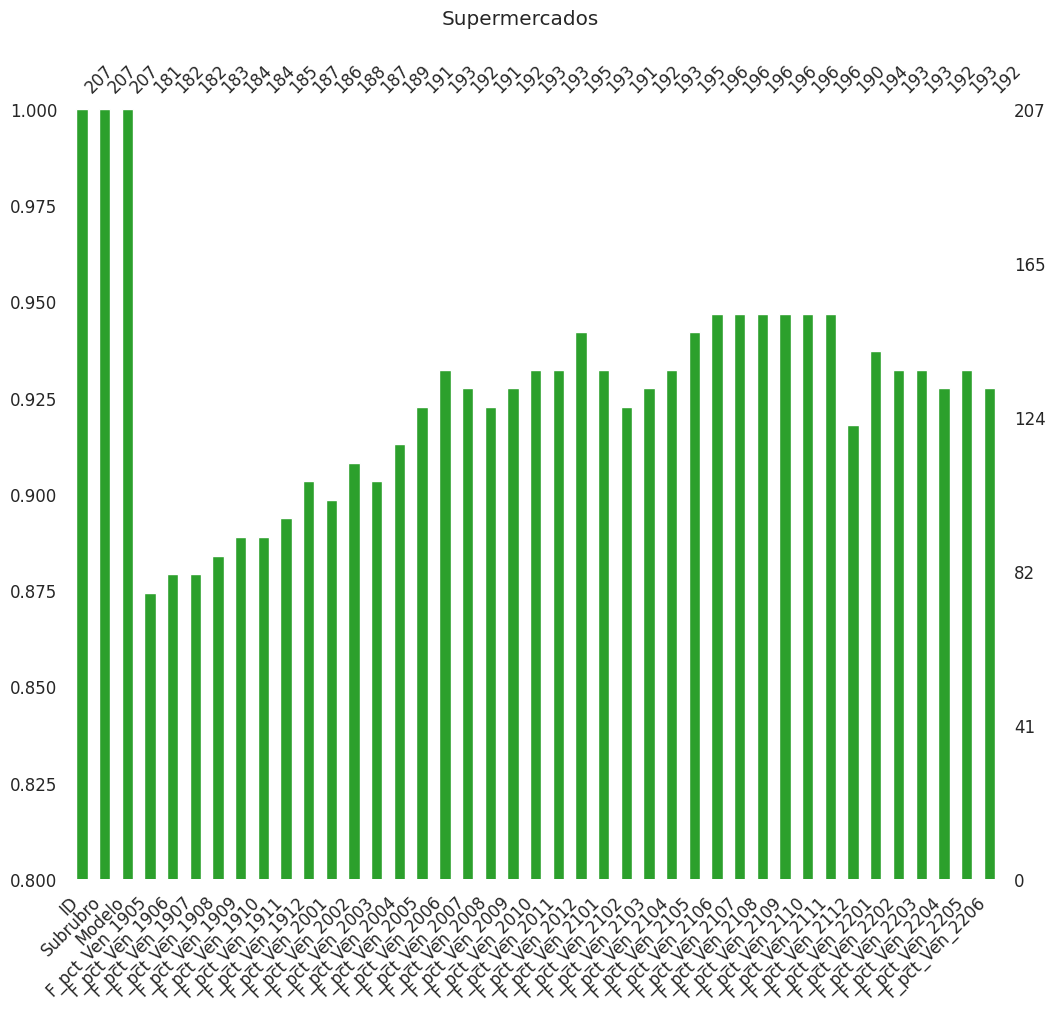

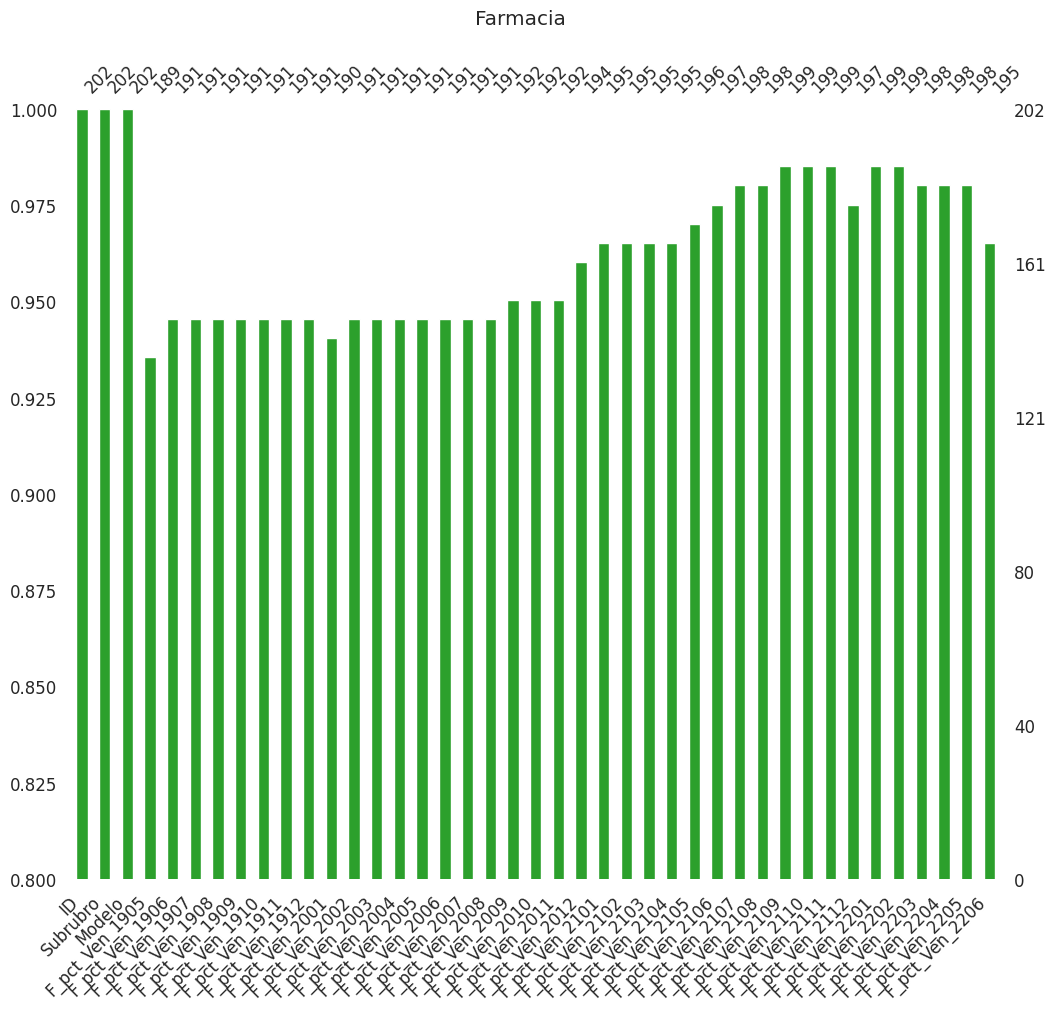

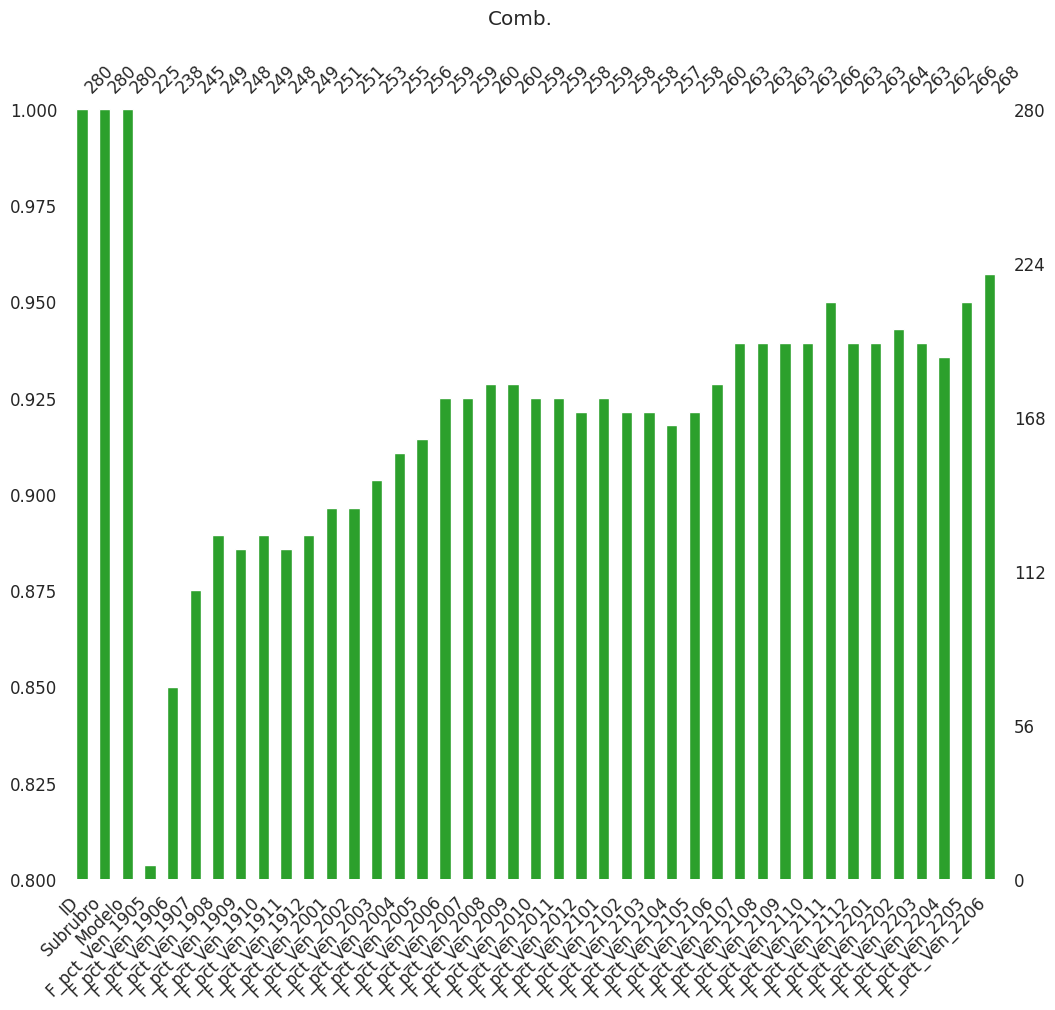

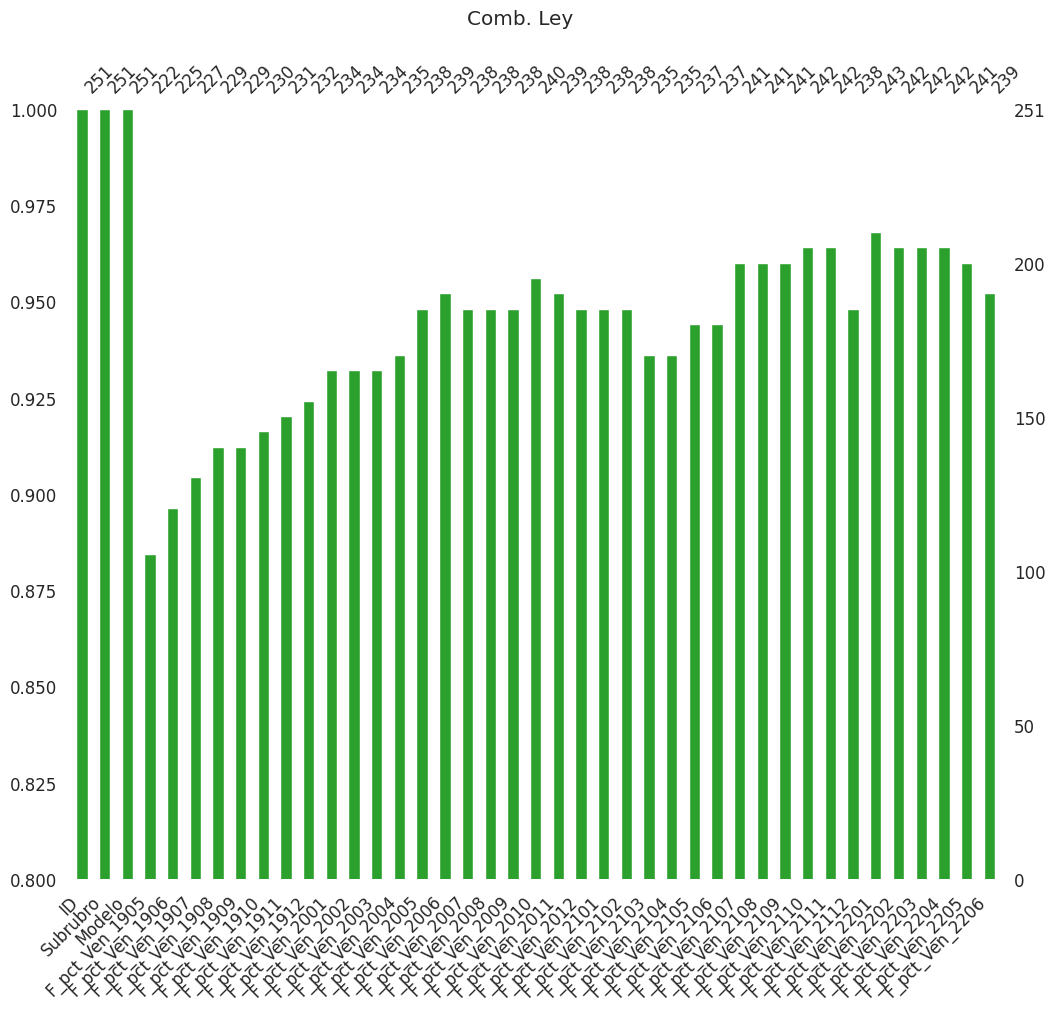

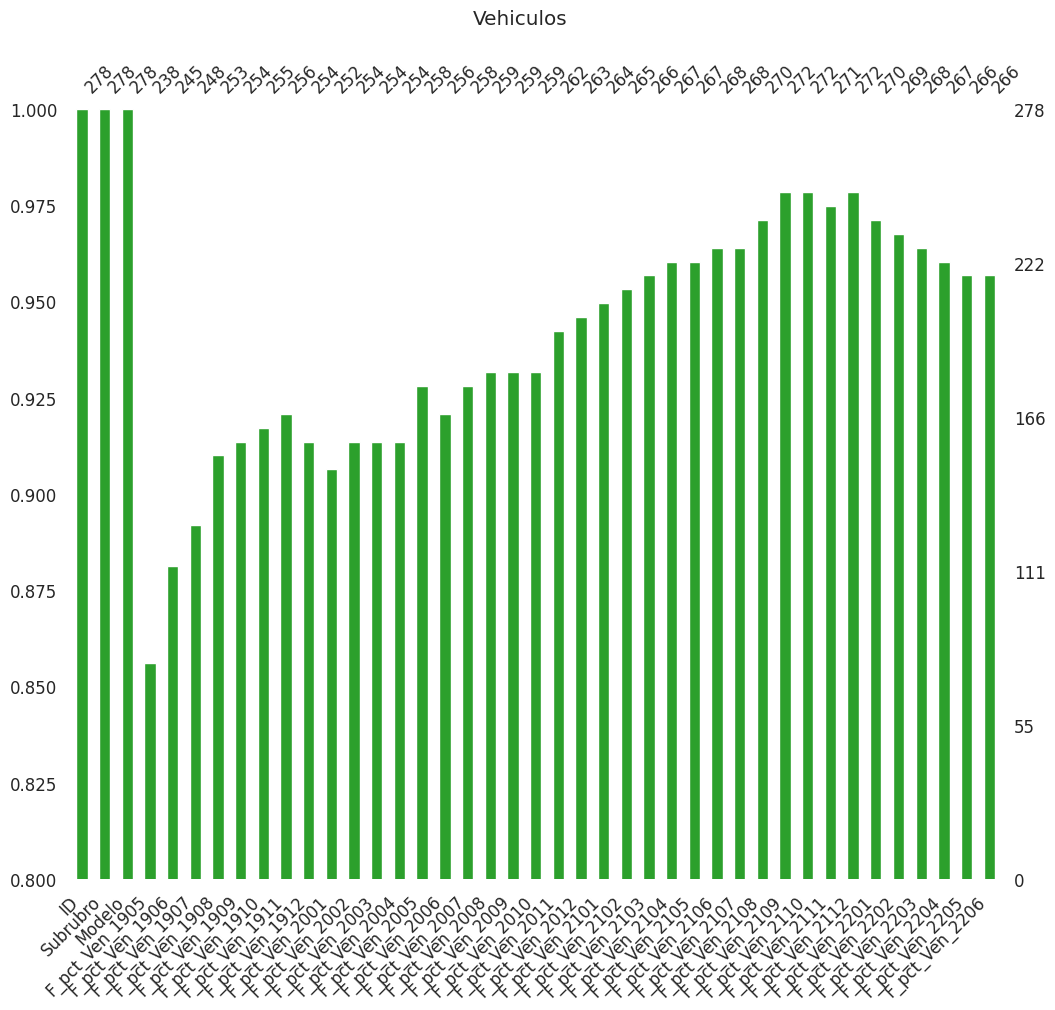

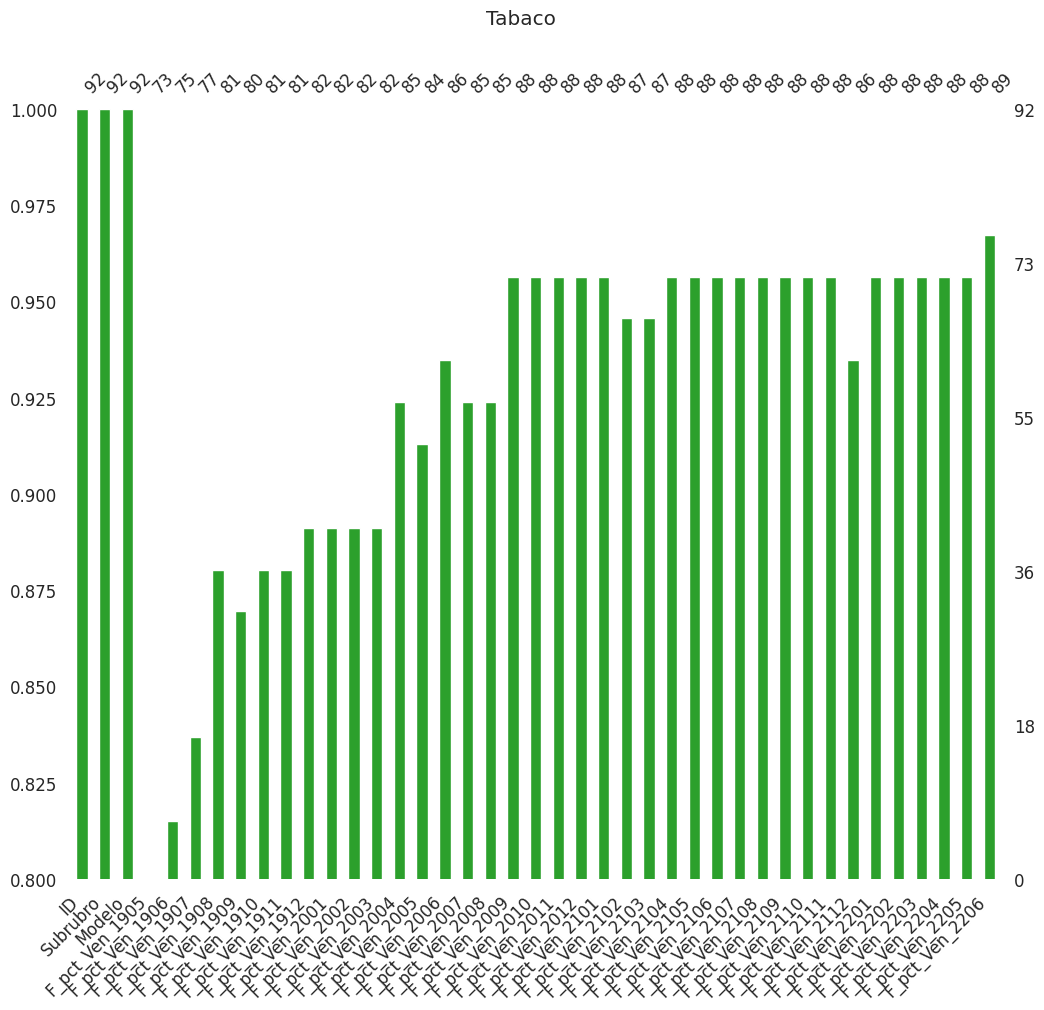

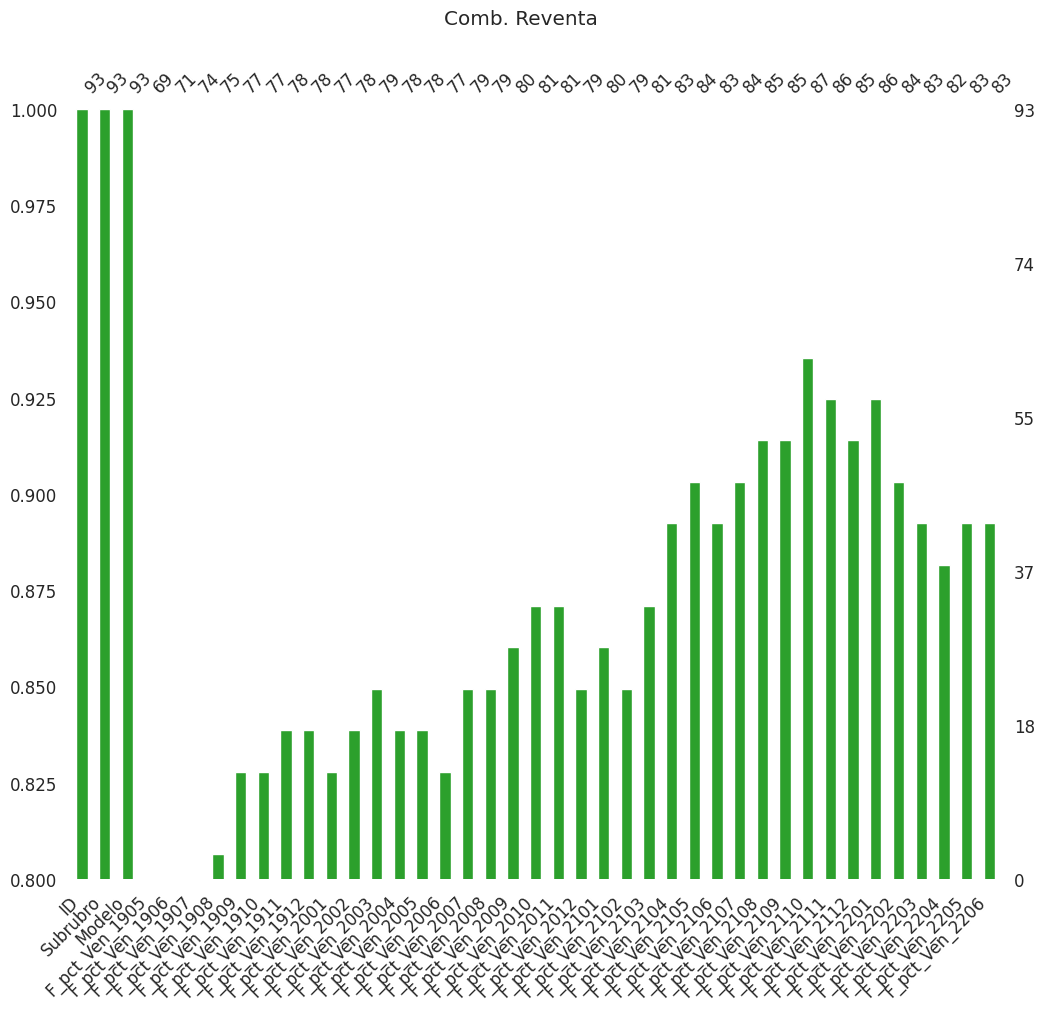

In [7]:
for sr in tp3.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()

    plt.suptitle(sr)
    msno.bar(tp3sr, fontsize=12, color="tab:green", figsize=(12, 10))
    plt.ylim(0.8, 1)
    plt.show()

## Cantidad de vacíos por vendedor (para ventas intercuatrimestrales)

De las 41 columnas, 3 son el `ID`, el `Subrubro` y `Modelo`. Las otras 38 corresponder a las variaciones porcentuales intercuatrimestrales. Si tomamos como aceptable un 10% de datos faltantes, podemos tolerar como máximo que haya 4 datos faltantes.

De los 4544 vendedores únicos, 3488 (el 77 %) no presentan ningún dato faltante. En el otro extremo, llegamos a tener vendedores con 37 datos faltantes, siendo que son 38 columnas. Acá hay algo raro, que debemos analizar.

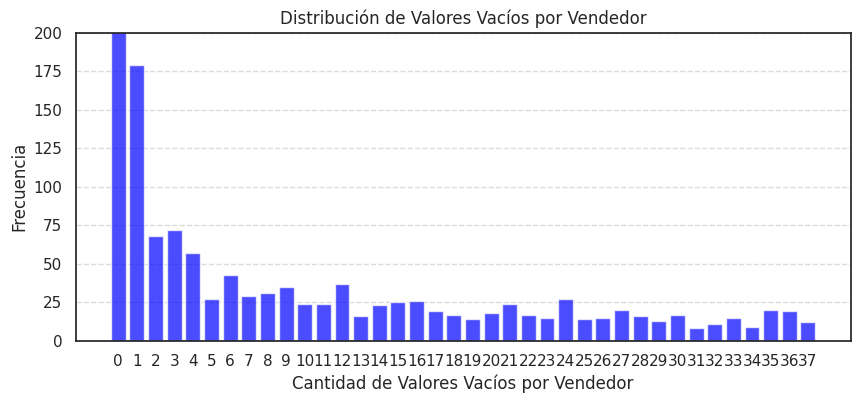

,Cantidad de Valores Vacíos,Número de Filas
0,0,3488
1,1,179
3,2,68
2,3,72
4,4,57
10,5,27
5,6,43
9,7,29
8,8,31
7,9,35


In [8]:
# Paso 1: Contar valores vacíos por fila
tp3_Fven['Vacios'] = tp3_Fven[F_Ven].isnull().sum(axis=1)
vacios_por_fila = tp3_Fven['Vacios'].copy()

# Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
resumen = vacios_por_fila.value_counts().reset_index()
resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')

plt.figure(figsize=(10, 4))  # Tamaño del gráfico
plt.bar(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], color='blue', alpha=0.7)
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor')
plt.xticks(resumen['Cantidad de Valores Vacíos'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 200)

plt.show()

display(resumen)

Analicemos esto mismo, pero por subrubro. `Miscelaneo` presenta la mayor cantidad de vendedores con diferente cantidad de datos faltantes. En todos los casos hay algún vendedor con más de 30 datos faltantes.

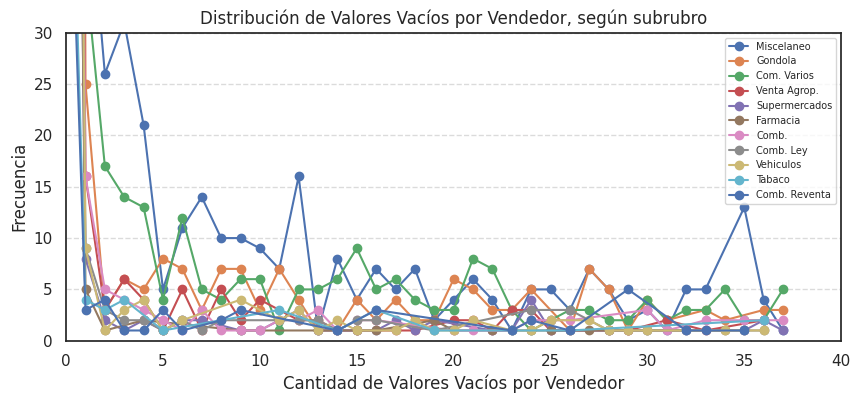

In [9]:
plt.figure(figsize=(10, 4))  # Tamaño del gráfico

for sr in tp3.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()

    # Paso 1: Contar valores vacíos por fila
    vacios_por_fila = tp3sr.isnull().sum(axis=1)

    # Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')

    plt.plot(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], label=sr, marker='o')
    
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor, según subrubro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 30)
plt.xlim(0, 40)

plt.legend(fontsize=7)

plt.show()

Vemos que en todos los subrubros tenemos modelo (por las dudas si nos había quedado alguno sin).

In [10]:
print('Subrubro \t Cantidad de modelos')
for sr in tp3.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()
    print(f"{sr} \t {tp3sr['Modelo'].sum()}")

Subrubro 	 Cantidad de modelos
Miscelaneo 	 20
Gondola 	 3
Com. Varios 	 4
Venta Agrop. 	 1
Supermercados 	 4
Farmacia 	 4
Comb. 	 6
Comb. Ley 	 4
Vehiculos 	 2
Tabaco 	 5
Comb. Reventa 	 1


Vamos a repetir la gráfica de valores faltantes por subrubro, pero ahora tomando únicamente a los modelo. Sólo se grafican aquellos subrubros donde algún modelo posee al menos 1 dato  faltante. Estos subrubros resultaron ser: `Comb.`, `Supermercados`, `Comb. Ley`, `Vehiculos` y `Tabaco`. Los últimos 4 casos presentan modelos con una cantidad de datos faltantes muy por encima del valor tolerable.

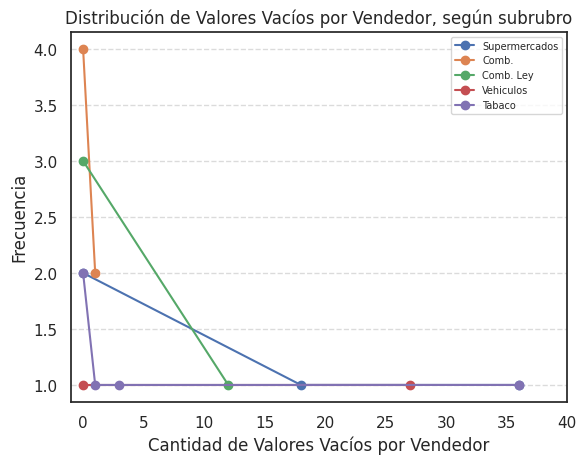

In [11]:
for sr in tp3.Subrubro.unique():

    tp3sr = tp3_Fven[(tp3_Fven['Modelo'] == 1) & (tp3_Fven['Subrubro'] == sr)].copy()

    # Paso 1: Contar valores vacíos por fila
    vacios_por_fila = tp3sr.isnull().sum(axis=1)

    # Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
    if len(resumen) > 1:
        plt.plot(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], label=sr, marker='o')
    
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor, según subrubro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 40)

plt.legend(fontsize=7)

plt.show()

Vamos a identificar a estos modelos con datos faltantes y corroborar si no es que pertenecen a más de un subrubro. Esto explicaría el porque de que aparezcan con datos faltantes en algún rubro.

In [12]:
# Busco los ID que tienen datos faltantes
ids = []
for sr in ['Supermercados', 'Comb.', 'Comb. Ley', 'Vehiculos', 'Tabaco']:

    tp3sr = tp3_Fven[(tp3_Fven['Modelo'] == 1) & (tp3_Fven['Subrubro'] == sr)]['ID'].copy()
    for k in tp3sr:
        ids.append(k)

ids = np.unique(np.array(ids))

# Veo caso a caso
for k in ids:
    tp3sr = tp3_Fven[(tp3_Fven['ID'] == k)].copy()
    vacios_por_fila = tp3sr.isnull().sum(axis=1)
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
    if len(resumen) > 1:
        print(f'\n\nVendedor {k}:')
        display(tp3sr)
        display(resumen)



Vendedor 306:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
480,306,Com. Varios,1,-0.495664,-0.245922,-0.028127,-0.416119,0.164137,0.204448,0.300149,1.153867,0.254681,0.084570,-0.717859,-0.919327,-0.929037,-0.597152,-0.034352,3.002629,8.654665,1.190492,0.999587,1.058817,0.874394,-0.253307,0.348049,0.004273,-0.448706,0.114884,-0.184090,-0.344033,0.131153,-0.002140,-0.147142,0.031084,-0.032954,0.389731,0.473385,0.783866,0.098906,0.022240,0
481,306,Comb.,1,-0.092596,-0.060213,0.053533,-0.000182,-0.105085,-0.001438,-0.069625,0.076039,0.246135,0.122198,-0.363343,-0.786711,-0.901123,-0.544555,-0.069063,1.253884,3.693492,0.259242,0.377280,0.821749,0.962296,0.496044,0.228534,-0.063115,-0.124485,-0.007870,0.077006,0.168858,0.081842,0.048184,-0.077975,-0.089063,-0.039978,0.010688,0.072768,-0.023762,-0.075284,0.059143,0
482,306,Miscelaneo,1,-0.425721,-0.083162,4.236186,-0.309724,0.060256,-0.134849,-0.811946,0.389102,0.596819,0.397699,-0.066822,-0.344028,-0.488041,-0.398303,-0.076379,0.092214,0.224948,0.084648,0.330969,1.039170,0.413257,0.527746,-0.095339,-0.359650,-0.217571,-0.324142,-0.032946,-0.035099,0.011881,0.588995,0.565820,0.378832,0.443114,-0.052967,-0.183487,-0.159784,-0.299663,0.328408,0
483,306,Supermercados,1,-0.527417,-0.538135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
484,306,Tabaco,1,-0.275271,-0.444455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36


,Cantidad de Valores Vacíos,Número de Filas
0,0,3
1,36,2




Vendedor 494:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
774,494,Comb.,1,0.043237,0.127218,0.092752,0.09427,-0.041805,0.023054,-0.066931,0.008699,-0.739867,-0.763125,-0.808191,-0.906968,-0.429497,-0.303181,0.003273,0.803908,0.166009,0.150956,0.070140,0.360934,0.311801,0.035943,0.198844,-0.068396,0.106672,-0.013751,-0.000932,0.116418,0.016813,0.222013,-0.081615,-0.175919,-0.238453,-0.226108,0.03426,0.051446,0.264477,0.257926,0
775,494,Comb. Ley,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.489179,-0.295398,0.019871,1.312431,0.935213,0.138073,0.089751,0.353801,-0.075637,0.170539,0.239201,-0.090561,-0.072983,-0.112773,-0.083630,0.006750,0.101409,0.195834,-0.011147,-0.009421,-0.233487,-0.193986,-0.03531,-0.108430,0.278361,0.286894,12


,Cantidad de Valores Vacíos,Número de Filas
0,0,1
1,12,1




Vendedor 496:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
777,496,Comb.,1,-0.149148,-0.594586,-0.030384,-0.165971,3.257126,1.132844,-0.121567,0.135307,-0.824351,-0.157616,-0.353409,-0.686805,-0.474727,-0.284149,0.048950,0.693196,0.172200,0.081819,0.057175,0.420135,0.316610,0.052971,0.193159,-0.086681,0.213973,0.110462,-0.064802,0.005188,-0.121892,-0.004459,-0.066114,-0.015682,-0.114979,-0.180420,0.023363,NaN,-0.075831,0.264016,1
778,496,Comb. Ley,1,-0.040622,-0.066164,-0.156172,-0.053055,-0.803696,-0.019423,0.059342,-0.022457,3.260781,-0.110178,-0.405148,-0.730765,-0.558478,-0.506094,-0.219190,1.672742,0.293336,-0.021271,-0.074636,-0.252638,0.029018,0.052114,0.146208,-0.098991,-0.115089,-0.174683,-0.185271,-0.064329,0.010077,0.388343,0.031275,0.164766,-0.069192,-0.237014,0.133980,-0.035696,0.322761,0.832276,0
779,496,Comb. Reventa,1,-0.312375,0.102973,1.188790,0.021662,0.006591,0.236371,0.525786,0.122524,-0.325730,-0.781332,-0.367471,-0.883986,-0.945466,-0.754624,-0.933428,4.875700,4.776288,12.629024,12.629024,-0.111543,1.178816,-0.076568,-0.076568,-0.600290,-0.580880,-0.580880,-0.580880,1.497749,1.382071,0.152161,0.943357,0.215463,-0.486671,-0.049632,0.601686,NaN,0.390352,2.548794,1


,Cantidad de Valores Vacíos,Número de Filas
1,0,1
0,1,2




Vendedor 599:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
940,599,Miscelaneo,1,-0.13917,-0.283775,0.310207,0.00731,-0.262844,-0.062519,-0.309449,0.210940,0.099178,1.075333,-0.334298,-0.618173,0.402425,-0.322572,1.418767,1.881204,0.032476,0.201775,0.229984,1.526002,0.020474,-0.351393,-0.310312,-0.524599,0.516977,0.574898,0.577210,0.557839,-0.440644,-0.299072,-0.387014,0.812498,0.659130,0.678302,0.470556,-0.793698,0.064398,0.244375,0
941,599,Tabaco,1,NaN,NaN,NaN,0.04393,-0.138290,0.520342,-0.161716,0.017244,-0.273390,-0.277418,-0.199979,-0.199979,-0.009966,-0.027218,-0.120019,-0.120019,0.203379,-0.375780,0.080798,-0.021080,-0.030486,0.407485,0.794848,1.294692,0.646885,1.007266,-0.149233,-0.529258,-0.499573,-0.568425,-0.543848,-0.311866,0.088256,0.530730,2.408301,1.678053,0.534493,0.675483,3


,Cantidad de Valores Vacíos,Número de Filas
0,0,1
1,3,1




Vendedor 798:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
1245,798,Miscelaneo,1,-0.123301,0.30535,0.716482,0.122014,0.004664,0.170964,-0.175865,0.545788,0.214613,-0.305607,-0.399103,-0.458571,0.424409,1.110977,1.393062,0.928032,-0.52203,0.052312,-0.039483,0.07713,0.277343,-0.511527,-0.352926,-0.492887,0.104091,0.635079,0.491623,0.233772,0.095371,-0.201766,0.108925,0.925464,0.426857,-0.040948,-0.122491,-0.442798,-0.215688,0.292898,0
1246,798,Vehiculos,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.122911,0.122911,0.122911,0.122911,0.000000,0.000000,0.000000,0.000000,27


,Cantidad de Valores Vacíos,Número de Filas
0,0,1
1,27,1




Vendedor 891:


,ID,Subrubro,Modelo,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Vacios
1392,891,Supermercados,1,0.306377,-0.257703,-0.355913,0.354431,-0.094963,-0.115590,0.211934,0.186710,-0.046084,0.254686,-0.140467,-0.40815,-0.193580,-0.259253,-0.028259,0.525892,0.230593,0.117857,-0.038634,0.158489,-0.228388,0.224741,0.388661,-0.267289,0.132605,-0.331009,-0.227018,0.053594,0.475687,0.047794,0.218929,-0.080310,-0.290504,0.465367,-0.015898,0.192358,0.184155,-0.191607,0
1393,891,Tabaco,1,NaN,-0.161883,-0.151379,0.105235,0.201754,0.411029,0.425055,0.683783,0.240880,0.270083,-0.091536,-0.32594,-0.535232,-0.127737,-0.126785,-0.379651,0.124064,-0.498910,-0.371125,-0.244891,-0.244891,-0.275944,-0.212103,-0.155584,-0.155584,-0.143836,-0.117443,-0.045714,0.136347,0.019259,-0.017225,0.159239,-0.194740,-0.081584,-0.075973,-0.172829,0.000000,0.000000,1


,Cantidad de Valores Vacíos,Número de Filas
0,0,1
1,1,1


---
# Tratamiento de datos faltantes

## Definir `Tipo_subrubro`

En primer lugar, vamos a definir una variable llamada `Tipo_subrubro` que determina si el rubro en cuestión es *Primario* o *Secundario*. Donde cada vendedor va a tener un único rubro *Primario* y ninguno, uno o más rubros *Secundario*.
* Los vendedores con un solo rubro, van a tener el valor *Primario* en todos los casos.
* Para los vendedores con varios rubros, se tendrá en cuenta la siguiente regla de decisión:
    * Es *Primario* el subrubro con menor cantidad de valores vacíos (en caso de empate define el que tenga el mayor volumen de ventas)
    * El resto de los subrubros son *Secundario*.

In [13]:
# Generamos la columna de "Vacíos" que teníamos sólo para F_ven
tp3['Vacios'] = tp3.isnull().sum(axis=1)

# Encuentra los ID que aparecen más de una vez
duplicados = tp3[tp3.duplicated(subset='ID', keep=False)].sort_values(by=['ID', 'Subrubro']).copy()
duplicados

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,Vacios
4,5,Com. Varios,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,0.450596,0.450596,0.450596,0.000000,0.000000,0.000000,0.737151,-0.257843,3.482344,3.482344,1.580284,5.039615,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,0.000000,3.914402,3.914402,3.914402,3.914402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,-0.237927,-0.237927,0.806316,-0.474648,-0.661039,-0.661039,1.797929,0.195350,20.298763,20.298763,1.580285,5.039614,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,-0.908025,3.914401,3.914401,3.914401,52.431941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076570,5.502070,5.502070,5.502070,3.482344,3.482344,-0.260113,-0.260113,-0.260113,-0.260113,-0.260113,1.093143,3.899373,-0.188794,-0.188794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.089056,4.501752,4.501752,12.040616,2.792752,6.219453,0.191694,0.191694,0.191694,2.515726,-0.676641,1.093143,3.899372,-0.188794,-0.188794,60
5,5,Venta Agrop.,0,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817641,0.932108,-0.634400,-0.459453,-0.247694,3.994712,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.300106,-0.300350,0.051135,-0.561633,1.578138,1.100276,1.401683,4.154978,0.420447,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817642,0.554519,-0.707520,-0.567563,-0.398155,3.966332,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.416755,-0.416958,-0.112452,-0.634694,1.578138,1.100276,1.370289,4.154978,0.420448,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,0.070318,1.112444,-0.402330,3.235124,0.959394,1.053732,4.343109,0.923179,2.065916,0.050343,0.042989,-0.451833,0.110609,1.010045,1.028173,-0.680585,-0.426733,-0.165543,0.298005,2.103071,1.563089,0.924838,0.299869,2.13

Necesitamos recuperar la variable `Ventas` del dataset antes de pivotear.

In [14]:
path = '../data/interim/tp3_registros_vendedores_abs.csv'
montos = pd.read_csv(path)
montos = montos.sort_values(by=['ID', 'Subrubro']).copy()
montos

,Subrubro,ID,Fecha,Ventas,Comision,Modelo,Omega,Dato_original
2021,Miscelaneo,0,2019-01-01,61155.916146,0.00,0,1,1
6631,Miscelaneo,0,2019-02-01,0.000000,0.00,0,1,1
11241,Miscelaneo,0,2019-03-01,0.000000,0.00,0,1,1
15851,Miscelaneo,0,2019-04-01,96651.469361,0.00,0,1,1
20461,Miscelaneo,0,2019-05-01,0.000000,0.00,0,1,1
...,...,...,...,...,...,...,...,...
174262,Miscelaneo,3131,2022-02-01,0.000000,0.00,0,1,0
178872,Miscelaneo,3131,2022-03-01,0.000000,0.00,0,1,0
183482,Miscelaneo,3131,2022-04-01,163688.033337,0.00,0,1,1
188092,Miscelaneo,3131,2022-05-01,205529.543519,0.00,0,1,1


In [15]:
# Crear la nueva variable 'Montos' que contendrá la suma de las Ventas por Subrubro e ID
montos['Montos'] = montos.groupby(['ID', 'Subrubro'])['Ventas'].transform('sum')
montos = montos[['ID', 'Subrubro', 'Montos']].copy()
montos = montos.drop_duplicates(subset=['ID', 'Subrubro'], keep='first').copy()
montos

,ID,Subrubro,Montos
2021,0,Miscelaneo,1.580649e+08
2022,1,Miscelaneo,9.074331e+08
2023,2,Miscelaneo,3.190490e+08
1413,4,Gondola,5.409168e+08
0,5,Com. Varios,8.633400e+06
...,...,...,...
3691,3122,Miscelaneo,1.759413e+07
578,3123,Com. Varios,5.975803e+04
2020,3126,Gondola,3.627312e+07
4281,3127,Vehiculos,9.985510e+05


In [16]:
# Mergear la variable Montos al df duplicados
duplicados = duplicados.merge(montos[['ID', 'Subrubro', 'Montos']], on=['ID', 'Subrubro'], how='left')
duplicados

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,Vacios,Montos
0,5,Com. Varios,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,0.450596,0.450596,0.450596,0.000000,0.000000,0.000000,0.737151,-0.257843,3.482344,3.482344,1.580284,5.039615,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,0.000000,3.914402,3.914402,3.914402,3.914402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,-0.237927,-0.237927,0.806316,-0.474648,-0.661039,-0.661039,1.797929,0.195350,20.298763,20.298763,1.580285,5.039614,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,-0.908025,3.914401,3.914401,3.914401,52.431941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076570,5.502070,5.502070,5.502070,3.482344,3.482344,-0.260113,-0.260113,-0.260113,-0.260113,-0.260113,1.093143,3.899373,-0.188794,-0.188794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.089056,4.501752,4.501752,12.040616,2.792752,6.219453,0.191694,0.191694,0.191694,2.515726,-0.676641,1.093143,3.899372,-0.188794,-0.188794,60,8.633400e+06
1,5,Venta Agrop.,0,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817641,0.932108,-0.634400,-0.459453,-0.247694,3.994712,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.300106,-0.300350,0.051135,-0.561633,1.578138,1.100276,1.401683,4.154978,0.420447,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817642,0.554519,-0.707520,-0.567563,-0.398155,3.966332,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.416755,-0.416958,-0.112452,-0.634694,1.578138,1.100276,1.370289,4.154978,0.420448,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,0.070318,1.112444,-0.402330,3.235124,0.959394,1.053732,4.343109,0.923179,2.065916,0.050343,0.042989,-0.451833,0.110609,1.010045,1.028173,-0.680585,-0.426733,-0.165543,0.298005,2.103071,1.563089,0.

In [17]:
# Aplicar la función de etiquetado por grupo (ID)
duplicados = duplicados.groupby('ID').apply(etiquetar_tipo_subrubro)
duplicados.reset_index(drop=True, inplace=True)

duplicados

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,Vacios,Montos,Tipo_subrubro
0,5,Com. Varios,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,0.450596,0.450596,0.450596,0.000000,0.000000,0.000000,0.737151,-0.257843,3.482344,3.482344,1.580284,5.039615,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,0.000000,3.914402,3.914402,3.914402,3.914402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450596,-0.237927,-0.237927,0.806316,-0.474648,-0.661039,-0.661039,1.797929,0.195350,20.298763,20.298763,1.580285,5.039614,0.000000,-0.834933,-0.834933,-0.834933,-0.834933,-0.908025,3.914401,3.914401,3.914401,52.431941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076570,5.502070,5.502070,5.502070,3.482344,3.482344,-0.260113,-0.260113,-0.260113,-0.260113,-0.260113,1.093143,3.899373,-0.188794,-0.188794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.089056,4.501752,4.501752,12.040616,2.792752,6.219453,0.191694,0.191694,0.191694,2.515726,-0.676641,1.093143,3.899372,-0.188794,-0.188794,60,8.633400e+06,Secundario
1,5,Venta Agrop.,0,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817641,0.932108,-0.634400,-0.459453,-0.247694,3.994712,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.300106,-0.300350,0.051135,-0.561633,1.578138,1.100276,1.401683,4.154978,0.420447,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,1.728359,4.203790,-0.580229,0.168523,-0.796961,0.110348,1.634003,3.817642,0.554519,-0.707520,-0.567563,-0.398155,3.966332,4.059159,2.752705,-0.469371,-0.682299,-0.432133,-0.485836,0.373180,-0.416755,-0.416958,-0.112452,-0.634694,1.578138,1.100276,1.370289,4.154978,0.420448,0.309896,-0.485097,0.387735,-0.355202,-0.817434,-0.023355,-0.205820,-0.243716,10.140715,0.070318,1.112444,-0.402330,3.235124,0.959394,1.053732,4.343109,0.923179,2.065916,0.050343,0.042989,-0.451833,0.110609,1.010045,1.028173,-0.680585,-0.426733,-0.165543,0.29

In [18]:
duplicados = duplicados[['ID', 'Subrubro', 'Tipo_subrubro']].copy()
duplicados

,ID,Subrubro,Tipo_subrubro
0,5,Com. Varios,Secundario
1,5,Venta Agrop.,Primario
2,9,Gondola,Primario
3,9,Miscelaneo,Secundario
4,10,Gondola,Primario
...,...,...,...
2765,3021,Venta Agrop.,Primario
2766,3050,Miscelaneo,Secundario
2767,3050,Vehiculos,Primario
2768,3083,Com. Varios,Primario


In [19]:
# Mergear la variable Tipo_subrubro al df tp3
tp3 = tp3.merge(duplicados[['ID', 'Subrubro', 'Tipo_subrubro']], on=['ID', 'Subrubro'], how='left')

# Para los vacíos, asignar Primario
tp3['Tipo_subrubro'].fillna("Primario", inplace=True)

tp3

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,Vacios,Tipo_subrubro
0,0,Miscelaneo,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.203215,-0.710101,-0.710101,-0.903021,-0.876897,-0.665474,-0.665474,0.000000,0.000000,0.000000,0.000000,0.000000,0.035706,1.598752,-0.147205,-0.147205,-0.011453,-0.661136,0.032632,-0.240964,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,-0.203215,-0.710101,-0.710101,-0.938750,-0.922251,-0.788721,-0.788721,0.000000,0.000000,0.000000,-0.954996,-0.954996,0.035706,1.598752,17.949262,17.949262,-0.011453,-0.661136,0.032632,-0.240964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.901913,-0.903021,-0.903021,-0.903021,-0.872501,-0.130651,-0.714718,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,360.379741,131.985243,131.985243,27.097036,27.097036,27.097036,27.097036,27.097036,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,36,Primario
1,1,Miscelaneo,0,0.539416,0.646451,0.056943,-0.282992,-0.447945,-0.435162,-0.180079,1.212314,0.443643,0.412318,-0.397606,-0.610106,-0.915708,0.012316,0.887189,0.021014,5.516357,-0.546791,-0.374321,1.336717,0.165957,0.383341,0.514635,-0.320647,0.473654,0.494902,-0.136233,-0.266387,-0.202242,-0.349614,-0.031099,0.900433,-0.155532,0.495029,0.226926,-0.151318,1.188350,0.390497,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,1.110347,0.185458,0.176078,-0.489700,-0.664758,-0.894072,0.009338,0.879161,0.026533,4.183454,-0.535172,-0.373324,1.276247,0.168231,0.334280,0.487384,-0.320647,0.452886,0.495895,-0.136233,-0.266387,-0.202242,-0.348981,-0.031099,0.900433,-0.155532,0.492585,0.227850,-0.151318,1.190775,0.390497,0.226868,0.313423,-0.477960,-0.38153

## Acciones según `Tipo_subrubro`

Una vez definida la variable `Tipo_subrubro`, vamos a tomar determinaciones respecto a qué hacer con los valores nulos.
Las reglas de decisión van a tener en cuenta a las variables `Modelo`, `Tipo_subrubro` y `Vacios`. A modo de referencia, son 136 las variables que contienen la variación porcentual.

| Modelo | Tipo_subrubro | Vacíos         | Decisión       |
|--------|---------------|----------------|----------------|
| 1      | Primario      | 0              | No hacer nada  |
| 1      | Primario      | Hasta 68 (50%) | Imputar        |
| 1      | Primario      | Más de 68      | Tirar          |
| 1      | Secundario    | 0              | No hacer nada  |
| 1      | Secundario    | Hasta 34 (25%) | Imputar        |
| 1      | Secundario    | Más de 34      | Tirar          |
| 0      | Primario      | 0              | No hacer nada  |
| 0      | Primario      | Hasta 14 (10%)  | Imputar        |
| 0      | Primario      | Más de 14       | Tirar          |
| 0      | Secundario    | 0              | No hacer nada  |
| 0      | Secundario    | Hasta 7 (5%)   | Imputar        |
| 0      | Secundario    | Más de 7      | Tirar          |

In [20]:
# Aplicar la función para crear la columna "Decisión"
tp3['Decision'] = tp3.apply(determinar_decision, axis=1)
tp3

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,Vacios,Tipo_subrubro,Decision
0,0,Miscelaneo,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.203215,-0.710101,-0.710101,-0.903021,-0.876897,-0.665474,-0.665474,0.000000,0.000000,0.000000,0.000000,0.000000,0.035706,1.598752,-0.147205,-0.147205,-0.011453,-0.661136,0.032632,-0.240964,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,-0.203215,-0.710101,-0.710101,-0.938750,-0.922251,-0.788721,-0.788721,0.000000,0.000000,0.000000,-0.954996,-0.954996,0.035706,1.598752,17.949262,17.949262,-0.011453,-0.661136,0.032632,-0.240964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.901913,-0.903021,-0.903021,-0.903021,-0.872501,-0.130651,-0.714718,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,0.580411,0.580411,0.580411,0.000000,0.000000,0.000000,452.547408,457.728829,457.728829,457.728829,360.379741,131.985243,131.985243,27.097036,27.097036,27.097036,27.097036,27.097036,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,36,Primario,Tirar
1,1,Miscelaneo,0,0.539416,0.646451,0.056943,-0.282992,-0.447945,-0.435162,-0.180079,1.212314,0.443643,0.412318,-0.397606,-0.610106,-0.915708,0.012316,0.887189,0.021014,5.516357,-0.546791,-0.374321,1.336717,0.165957,0.383341,0.514635,-0.320647,0.473654,0.494902,-0.136233,-0.266387,-0.202242,-0.349614,-0.031099,0.900433,-0.155532,0.495029,0.226926,-0.151318,1.188350,0.390497,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,1.110347,0.185458,0.176078,-0.489700,-0.664758,-0.894072,0.009338,0.879161,0.026533,4.183454,-0.535172,-0.373324,1.276247,0.168231,0.334280,0.487384,-0.320647,0.452886,0.495895,-0.136233,-0.266387,-0.202242,-0.348981,-0.031099,0.900433,-0.155532,0.492585,0.227850,-0.151318,1.190775,0.390497,0.226868,0.313423,-0.

### Tirar
Descartamos todos aquellos registros identificados con `Tirar`, guardando el resultado.

In [27]:
tp3_limpio = tp3[tp3['Decision'] != 'Tirar'].copy()
tp3_limpio.drop(columns=['Decision', 'Vacios', 'Tipo_subrubro'], inplace=True)
tp3_limpio.reset_index(inplace=True, drop=True)
tp3_limpio

,ID,Subrubro,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,F_pct_Com_2003,F_pct_Com_2004,F_pct_Com_2005,F_pct_Com_2006,F_pct_Com_2007,F_pct_Com_2008,F_pct_Com_2009,F_pct_Com_2010,F_pct_Com_2011,F_pct_Com_2012,F_pct_Com_2101,F_pct_Com_2102,F_pct_Com_2103,F_pct_Com_2104,F_pct_Com_2105,F_pct_Com_2106,F_pct_Com_2107,F_pct_Com_2108,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206,F_pct_Ven_1905,F_pct_Ven_1906,F_pct_Ven_1907,F_pct_Ven_1908,F_pct_Ven_1909,F_pct_Ven_1910,F_pct_Ven_1911,F_pct_Ven_1912,F_pct_Ven_2001,F_pct_Ven_2002,F_pct_Ven_2003,F_pct_Ven_2004,F_pct_Ven_2005,F_pct_Ven_2006,F_pct_Ven_2007,F_pct_Ven_2008,F_pct_Ven_2009,F_pct_Ven_2010,F_pct_Ven_2011,F_pct_Ven_2012,F_pct_Ven_2101,F_pct_Ven_2102,F_pct_Ven_2103,F_pct_Ven_2104,F_pct_Ven_2105,F_pct_Ven_2106,F_pct_Ven_2107,F_pct_Ven_2108,F_pct_Ven_2109,F_pct_Ven_2110,F_pct_Ven_2111,F_pct_Ven_2112,F_pct_Ven_2201,F_pct_Ven_2202,F_pct_Ven_2203,F_pct_Ven_2204,F_pct_Ven_2205,F_pct_Ven_2206,Y_pct_Com_2001,Y_pct_Com_2002,Y_pct_Com_2003,Y_pct_Com_2004,Y_pct_Com_2005,Y_pct_Com_2006,Y_pct_Com_2007,Y_pct_Com_2008,Y_pct_Com_2009,Y_pct_Com_2010,Y_pct_Com_2011,Y_pct_Com_2012,Y_pct_Com_2101,Y_pct_Com_2102,Y_pct_Com_2103,Y_pct_Com_2104,Y_pct_Com_2105,Y_pct_Com_2106,Y_pct_Com_2107,Y_pct_Com_2108,Y_pct_Com_2109,Y_pct_Com_2110,Y_pct_Com_2111,Y_pct_Com_2112,Y_pct_Com_2201,Y_pct_Com_2202,Y_pct_Com_2203,Y_pct_Com_2204,Y_pct_Com_2205,Y_pct_Com_2206,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,1,Miscelaneo,0,0.539416,0.646451,0.056943,-0.282992,-0.447945,-0.435162,-0.180079,1.212314,0.443643,0.412318,-0.397606,-0.610106,-0.915708,0.012316,0.887189,0.021014,5.516357,-0.546791,-0.374321,1.336717,0.165957,0.383341,0.514635,-0.320647,0.473654,0.494902,-0.136233,-0.266387,-0.202242,-0.349614,-0.031099,0.900433,-0.155532,0.495029,0.226926,-0.151318,1.188350,0.390497,0.560242,0.592999,0.011296,-0.266983,-0.441363,-0.430089,-0.167779,1.110347,0.185458,0.176078,-0.489700,-0.664758,-0.894072,0.009338,0.879161,0.026533,4.183454,-0.535172,-0.373324,1.276247,0.168231,0.334280,0.487384,-0.320647,0.452886,0.495895,-0.136233,-0.266387,-0.202242,-0.348981,-0.031099,0.900433,-0.155532,0.492585,0.227850,-0.151318,1.190775,0.390497,0.226868,0.313423,-0.477960,-0.381531,-0.932822,-0.192445,-0.067888,-0.119305,-0.207038,-0.352042,-0.288708,-0.069782,-0.359565,-0.365337,0.788443,0.620815,10.196514,-0.062783,-0.181429,0.164579,0.370721,0.344972,0.267605,-0.052857,-0.007227,0.453562,0.026820,0.183219,0.474250,0.352044,0.033256,0.067723,-0.570520,-0.481407,-0.929850,-0.323481,-0.201953,-0.273751,-0.349094,-0.448222,-0.399058,-0.216658,-0.358553,-0.373998,0.751580,0.587407,7.797906,-0.072231,-0.194876,0.134443,0.354040,0.299397,0.244799,-0.052857,-0.021218,0.453562,0.027594,0.183219,0.475884,0.351147
1,2,Miscelaneo,0,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,-0.134293,0.477774,0.992702,0.200248,-0.274377,-0.525708,-0.670562,-0.349881,0.971304,1.444361,4.664442,3.690998,1.095724,0.655232,-0.315512,-0.683443,-0.052528,-0.247789,-0.136519,0.713244,-0.359352,-0.026916,0.267393,0.628888,-0.062857,-0.088358,-0.383918,-0.383410,-0.416669,-0.361089,-0.002838,-0.280012,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,-0.134293,0.477774,0.678065,0.010735,-0.388949,-0.983314,-0.636293,-0.263252,1.073850,57.508963,4.130725,3.139416,0.992096,0.655232,-0.302983,-0.683443,-0.052528,-0.247789,-0.133563,0.758891,-0.3

In [28]:
tp3_limpio.to_csv('../data/interim/tp3_pivot_Tirar.csv', index=False)

Comparamos los datasets antes y después de tirar.

In [69]:
print('Cantidad de registros en el dataset pivoteado:')
print(f'\tAntes de tirar >> {tp3.shape[0]}')
print(f'\tDespués de tirar >> {tp3_limpio.shape[0]}')
d = tp3.shape[0]-tp3_limpio.shape[0]
print(f'\t\tSe tienen {d} ({100*d/tp3.shape[0]:.0f}%) "vendedores únicos" menos.\n')

print('Cantidad de vendedores modelo:')
print(f'\tAntes de tirar >> {len(tp3[tp3["Modelo"]==1])}')
print(f'\tDespués de tirar >> {len(tp3_limpio[tp3_limpio["Modelo"]==1])}')
d = len(tp3[tp3["Modelo"]==1]) - len(tp3_limpio[tp3_limpio["Modelo"]==1])
print(f'\t\tSe tienen {d} ({100*d/len(tp3[tp3["Modelo"]==1]):.0f}%) "vendedores únicos" modelo menos.\n')

print('Subrubros con al menos 1 vendedor modelo:')
print(f'\tCantidad total de subrubros >> {tp3["Subrubro"].nunique()}')
print(f'\tAntes de tirar >> {tp3[tp3["Modelo"]==1]["Subrubro"].nunique()}')
print(f'\tDespués de tirar >> {tp3_limpio[tp3_limpio["Modelo"]==1]["Subrubro"].nunique()}')
d = tp3[tp3["Modelo"]==1]["Subrubro"].nunique() - tp3_limpio[tp3_limpio["Modelo"]==1]["Subrubro"].nunique()
print(f'\t\tSe tienen {d} ({100*d/tp3[tp3["Modelo"]==1]["Subrubro"].nunique():.0f}%) subrubros sin vendedores modelo.\n')

Cantidad de registros en el dataset pivoteado:
	Antes de tirar >> 4544
	Después de tirar >> 3180
		Se tienen 1364 (30%) "vendedores únicos" menos.

Cantidad de vendedores modelo:
	Antes de tirar >> 54
	Después de tirar >> 46
		Se tienen 8 (15%) "vendedores únicos" modelo menos.

Subrubros con al menos 1 vendedor modelo:
	Cantidad total de subrubros >> 11
	Antes de tirar >> 11
	Después de tirar >> 10
		Se tienen 1 (9%) subrubros sin vendedores modelo.



In [70]:
# Crear los DataFrames "antes" y "ahora"
antes = tp3.pivot_table(index='Subrubro', columns='Modelo', aggfunc='size', fill_value=0)
ahora = tp3_limpio.pivot_table(index='Subrubro', columns='Modelo', aggfunc='size', fill_value=0)

diferencia = ahora - antes
porcentual = (ahora - antes)/antes*100

# Agregar nombres a los DataFrames
antes = antes.rename(columns=lambda x: (x, 'antes'))
ahora = ahora.rename(columns=lambda x: (x, 'después'))
diferencia = diferencia.rename(columns=lambda x: (x, 'diferencia'))
porcentual = porcentual.rename(columns=lambda x: (x, 'porcentual'))

# Concatenar los DataFrames con nombres
resultado = pd.concat([antes, ahora, diferencia, porcentual], axis=1)
resultado.columns = pd.MultiIndex.from_tuples(resultado.columns)
resultado.columns = resultado.columns.swaplevel(0, 1)  # Intercambiar el orden de los niveles de las columnas
resultado.columns.names = ['Tabla', 'Modelo']  # Cambiar el orden de los nombres de los niveles

# Mostrar el resultado
resultado

Tabla         antes     después     diferencia    porcentual       
Modelo            0   1       0   1          0  1          0      1
Subrubro                                                           
Com. Varios     555   4     297   4       -258  0 -46.486486    0.0
Comb.           274   6     183   6        -91  0 -33.211679    0.0
Comb. Ley       247   4     192   3        -55 -1 -22.267206  -25.0
Comb. Reventa    92   1      45   0        -47 -1 -51.086957 -100.0
Farmacia        198   4     169   4        -29  0 -14.646465    0.0
Gondola         595   3     406   3       -189  0 -31.764706    0.0
Miscelaneo     1637  20    1220  20       -417  0 -25.473427    0.0
Supermercados   203   4     134   2        -69 -2 -33.990148  -50.0
Tabaco           87   5      20   2        -67 -3 -77.011494  -60.0
Vehiculos       276   2     220   1        -56 -1 -20.289855  -50.0
Venta Agrop.    326   1     248   1        -78  0 -23.926380    0.0

### Imputar con KNN

Transponemos para imputar, porque KNN funciona asignando el valor en función de las otras columnas. Pasamos de tener los vendedores en las filas con la evolución en el tiempo en las columnas a tener un dado momento en el tiempo en las filas con los diferentes vendedores en las columnas.

In [ ]:
tp3_Fven_limpio

In [ ]:
msno.bar(tp3_Fven_limpio, fontsize=12, color="tab:green", figsize=(24, 20))
plt.ylim(0.8, 1)
plt.show()

In [ ]:
X = tp3_Fven_limpio.iloc[:, 2:41].transpose() 
X.head(10)

La imputación se hace considerando los 5 vecinos más cercanos.

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(X)
X_knn5_imputed_arr = knn_imputer.transform(X)

X_knn5_imputed_df_trans = pd.DataFrame(X_knn5_imputed_arr, columns=X.columns)

# vuelve a transponer para volver a la forma original
X_knn5_imputed_df = X_knn5_imputed_df_trans.transpose()
X_knn5_imputed_df.head()

In [ ]:
X_knn5_imputed = tp3_Fven_limpio.copy()
# inserto el df imputado en la misma forma de df del que se partió para tener las otras features categóricas (Subrubro, principalmente)
X_knn5_imputed.iloc[:, 2:41] = X_knn5_imputed_df

X_knn5_imputed.tail(10)